In [1]:
import time
import math
import random
import csv
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from sklearn.model_selection import train_test_split

from gensim.corpora import Dictionary
from torchtext.data.metrics import bleu_score

import spacy

In [2]:
DATASETS_PATH = '../input/qed-filtered/'
MODELS_PATH = '../input/finetunedweights/'

SRC_LANGUAGE = 'ru'
TGT_LANGUAGE = 'en'

BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

TRAIN_SIZE_RATIO = 0.7
EVAL_SIZE_RATIO = 0.25
TEST_SIZE_RATIO = 0.05
MAX_TOKEN_LEN = 50
MIN_LEN2SKIP_FILTER = 4
BATCH_SIZE = 128
TEST_BATCH_SIZE = 32

In [3]:
def init_random_seed(value=42):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed()

### Data Explore

In [8]:
with open(DATASETS_PATH + 'QED.en-ru.'+SRC_LANGUAGE, 'r', encoding='utf-8') as fstream:
    src_data = [line.rstrip() for line in fstream]

with open(DATASETS_PATH + 'QED.en-ru.'+TGT_LANGUAGE, 'r', encoding='utf-8') as fstream:
    tgt_data = [line.rstrip() for line in fstream]

In [8]:
gen = iter(range(0, len(src_data), 5))

In [9]:
next_idx = next(gen)
print(next_idx)
print(src_data[next_idx:next_idx+5])
print(tgt_data[next_idx:next_idx+5])

0

['Вы полагаете, что много знаете о коренных американцах из известных фильмов, книг и школьных предметов, но, оказывается, что многое из известного нам о знаменитых коренных американцах не совсем правда.', 'К примеру, история Сакагавеи.', 'Вам мог запомниться образ красивой индианки, жившей экзотической жизнью и служившей мудрой проводницей в легендарной экспедиции Льюиса и Кларка, не так ли?', 'Ну... всё было немного по-другому.', 'Не многое известно о раннем детстве Сакагавеи, но мы точно знаем, что она родилась в 1788 году в племени агайдика северных шошонов, проживавших на территории нынешнего штата Айдахо.']

["You might think you know a lot about Native Americans through popular movies, books, and classes in school, but it turns out that a lot of what we think we know about famous Native American figures isn't quite right.", 'Take Sacajawea for example.', "You probably remember her as a beautiful Indian woman who lived an exotic life serving as the all-knowing guide for Lewis a

In [10]:
print(src_data[680:685])
print(tgt_data[680:685])

['[Стол] Зелёный.', '[Доска]', 'Зрители:', 'Красный.', 'Дафна Бавельер: Красный.']

['["Table"]', 'Green.', '["Board"]', 'Audience:', 'Red.Daphne Bavelier:']


In [59]:
df = pd.DataFrame({'src_sentence': src_data, 'tgt_sentence': tgt_data})
df

,src_sentence,tgt_sentence
0,"Вы полагаете, что много знаете о коренных амер...",You might think you know a lot about Native Am...
1,"К примеру, история Сакагавеи.",Take Sacajawea for example.
2,"Вам мог запомниться образ красивой индианки, ж...",You probably remember her as a beautiful India...
3,Ну... всё было немного по-другому.,"Well, that's not exactly how it happened."
4,"Не многое известно о раннем детстве Сакагавеи,...",Not much is known about Sacajawea's early chil...
...,...,...
563695,"Поэтому, когда я смотрю вверх в ночное небо и ...",So that when I look up at the night sky and I ...
563696,"Когда я размышляю над этим фактом, я смотрю вв...","When I reflect on that fact, I look up- many p..."
563697,Существует уровень взаимосвязи.,There's a level of connectivity.
563698,"Именно этого вы реально хотите в жизни, вы хот...","That's really what you want in life, you want ..."


### Data Filtering

In [60]:
lang_mix_filter = ~df.tgt_sentence.str.contains(r"\b[а-яА-ЯёЁ]+\b") & ~df.src_sentence.str.contains(r'\b[a-zA-Z]+\b')
df = df[lang_mix_filter]

In [61]:
df.src_sentence = df.src_sentence.str.replace(r'[^a-zA-Zа-яА-ЯёЁ\s\d\.\?!\:\-—,\"`\']', '', regex=True)
df.tgt_sentence = df.tgt_sentence.str.replace(r'[^a-zA-Zа-яА-ЯёЁ\s\d\.\?!\:\-—,\"`\']', '', regex=True)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\2016132386.py:1: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.src_sentence = df.src_sentence.str.replace(r'[^a-zA-Zа-яА-ЯёЁ\s\d\.\?!\:\-—,\"`\']', '', regex=True)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\2016132386.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.tgt_sentence = df.tgt_sentence.str.replace(r'[^a-zA-Zа-яА-ЯёЁ\s\d\.\?!\:\-—,\"`\']', '', regex=True)


In [4]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 9.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 158.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 4.5 MB/s eta 0:00:0000:0100:010m
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [5]:
spacy_src = spacy.load('ru_core_news_sm')
spacy_tgt = spacy.load('en_core_web_sm')
spacy_tools = {SRC_LANGUAGE: spacy_src, TGT_LANGUAGE: spacy_tgt}

In [6]:
def corpus_tokenizer(data, language):
    tokenized_corp = [[token.text for token in spacy_tools[language].tokenizer(doc.lower())] for doc in  data]
    return tokenized_corp

In [7]:
def doc_tokenizer(data, language):
    tokenized_doc = [token.text for token in spacy_tools[language].tokenizer(data.lower())]
    return tokenized_doc

In [65]:
df['src_tokens'] = tokenizer(df.src_sentence.tolist(), SRC_LANGUAGE)
df['tgt_tokens'] = tokenizer(df.tgt_sentence.tolist(), TGT_LANGUAGE)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\1970623735.py:1: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['src_tokens'] = tokenizer(df.src_sentence.tolist(), SRC_LANGUAGE)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\1970623735.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['tgt_tokens'] = tokenizer(df.tgt_sentence.tolist(), TGT_LANGUAGE)


In [72]:
df

,src_sentence,tgt_sentence,src_tokens,tgt_tokens
0,"Вы полагаете, что много знаете о коренных амер...",You might think you know a lot about Native Am...,"[вы, полагаете, ,, что, много, знаете, о, коре...","[you, might, think, you, know, a, lot, about, ..."
1,"К примеру, история Сакагавеи.",Take Sacajawea for example.,"[к, примеру, ,, история, сакагавеи, .]","[take, sacajawea, for, example, .]"
2,"Вам мог запомниться образ красивой индианки, ж...",You probably remember her as a beautiful India...,"[вам, мог, запомниться, образ, красивой, индиа...","[you, probably, remember, her, as, a, beautifu..."
3,Ну... всё было немного по-другому.,"Well, that's not exactly how it happened.","[ну, ..., всё, было, немного, по, -, другому, .]","[well, ,, that, 's, not, exactly, how, it, hap..."
4,"Не многое известно о раннем детстве Сакагавеи,...",Not much is known about Sacajawea's early chil...,"[не, многое, известно, о, раннем, детстве, сак...","[not, much, is, known, about, sacajawea, 's, e..."
...,...,...,...,...
563695,"Поэтому, когда я смотрю вверх в ночное небо и ...",So that when I look up at the night sky and I ...,"[поэтому, ,, когда, я, смотрю, вверх, в, ночно...","[so, that, when, i, look, up, at, the, night, ..."
563696,"Когда я размышляю над этим фактом, я смотрю вв...","When I reflect on that fact, I look up- many p...","[когда, я, размышляю, над, этим, фактом, ,, я,...","[when, i, reflect, on, that, fact, ,, i, look,..."
563697,Существует уровень взаимосвязи.,There's a level of connectivity.,"[существует, уровень, взаимосвязи, .]","[there, 's, a, level, of, connectivity, .]"
563698,"Именно этого вы реально хотите в жизни, вы хот...","That's really what you want in life, you want ...","[именно, этого, вы, реально, хотите, в, жизни,...","[that, 's, really, what, you, want, in, life, ..."


In [71]:
empy_obs_filter = ~((df.src_sentence == '') | (df.tgt_sentence == ''))
df = df.loc[empy_obs_filter]

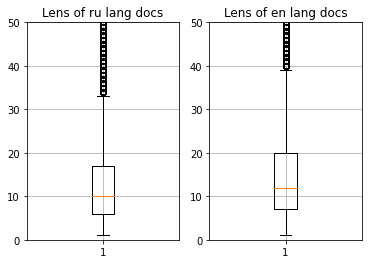

In [78]:
fig, axis = plt.subplots(1, 2)
axis[0].boxplot(df.src_tokens.apply(len))
axis[0].set_ylim(0, MAX_TOKEN_LEN)
axis[0].grid(True)
axis[0].set_title(f'Lens of {SRC_LANGUAGE} lang docs')

axis[1].boxplot(df.tgt_tokens.apply(len))
axis[1].set_ylim(0, MAX_TOKEN_LEN)
axis[1].set_title(f'Lens of {TGT_LANGUAGE} lang docs')
axis[1].grid(True)

In [93]:
tokens_length_filter = ~((df.src_tokens.apply(len) > MAX_TOKEN_LEN) | (df.tgt_tokens.apply(len) > MAX_TOKEN_LEN))
df = df[tokens_length_filter]

In [94]:
df

,src_sentence,tgt_sentence,src_tokens,tgt_tokens
0,"Вы полагаете, что много знаете о коренных амер...",You might think you know a lot about Native Am...,"[вы, полагаете, ,, что, много, знаете, о, коре...","[you, might, think, you, know, a, lot, about, ..."
1,"К примеру, история Сакагавеи.",Take Sacajawea for example.,"[к, примеру, ,, история, сакагавеи, .]","[take, sacajawea, for, example, .]"
2,"Вам мог запомниться образ красивой индианки, ж...",You probably remember her as a beautiful India...,"[вам, мог, запомниться, образ, красивой, индиа...","[you, probably, remember, her, as, a, beautifu..."
3,Ну... всё было немного по-другому.,"Well, that's not exactly how it happened.","[ну, ..., всё, было, немного, по, -, другому, .]","[well, ,, that, 's, not, exactly, how, it, hap..."
4,"Не многое известно о раннем детстве Сакагавеи,...",Not much is known about Sacajawea's early chil...,"[не, многое, известно, о, раннем, детстве, сак...","[not, much, is, known, about, sacajawea, 's, e..."
...,...,...,...,...
563695,"Поэтому, когда я смотрю вверх в ночное небо и ...",So that when I look up at the night sky and I ...,"[поэтому, ,, когда, я, смотрю, вверх, в, ночно...","[so, that, when, i, look, up, at, the, night, ..."
563696,"Когда я размышляю над этим фактом, я смотрю вв...","When I reflect on that fact, I look up- many p...","[когда, я, размышляю, над, этим, фактом, ,, я,...","[when, i, reflect, on, that, fact, ,, i, look,..."
563697,Существует уровень взаимосвязи.,There's a level of connectivity.,"[существует, уровень, взаимосвязи, .]","[there, 's, a, level, of, connectivity, .]"
563698,"Именно этого вы реально хотите в жизни, вы хот...","That's really what you want in life, you want ...","[именно, этого, вы, реально, хотите, в, жизни,...","[that, 's, really, what, you, want, in, life, ..."


In [97]:
df['src_tokens_len'] = df.src_tokens.apply(len)
df['tgt_tokens_len'] = df.tgt_tokens.apply(len)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\2988169284.py:1: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['src_tokens_len'] = df.src_tokens.apply(len)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\2988169284.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['tgt_tokens_len'] = df.tgt_tokens.apply(len)


In [98]:
df['tokens_len_ratio'] = df[['src_tokens_len', 'tgt_tokens_len']].max(1) / df[['src_tokens_len', 'tgt_tokens_len']].min(1)

C:\Users\Uer\AppData\Local\Temp\ipykernel_8824\608239914.py:1: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['tokens_len_ratio'] = df[['src_tokens_len', 'tgt_tokens_len']].max(1) / df[['src_tokens_len', 'tgt_tokens_len']].min(1)


In [100]:
df.tokens_len_ratio.describe()

count    513483.000000
mean          1.367947
std           0.807494
min           1.000000
25%           1.076923
50%           1.200000
75%           1.416667
max          50.000000
Name: tokens_len_ratio, dtype: float64

In [105]:
tokens_len_diff_filter = df.tokens_len_ratio <= (df.tokens_len_ratio.mean() + df.tokens_len_ratio.std())
min_len_exception = df[['src_tokens_len', 'tgt_tokens_len']].max(1) < MIN_LEN2SKIP_FILTER
df = df[tokens_len_diff_filter | min_len_exception]

In [109]:
df[['src_sentence', 'tgt_sentence']].sample(frag=1).to_csv(f'{DATASETS_PATH}{SRC_LANGUAGE}_to_{TGT_LANGUAGE}_QED_filtered.csv', index=False)

In [ ]:
del df

### Preparing Model input

In [8]:
with open(DATASETS_PATH + f'{SRC_LANGUAGE}_to_{TGT_LANGUAGE}_QED_filtered.csv', 'r', encoding='utf-8') as fstream:
    reader = csv.reader(fstream)
    next(reader)
    data_src = []
    data_tgt = []
    data = {SRC_LANGUAGE: data_src, TGT_LANGUAGE: data_tgt}
    for (src_doc, tgt_doc) in reader:
        data[SRC_LANGUAGE].append(src_doc)
        data[TGT_LANGUAGE].append(tgt_doc) 

In [9]:
src_tokenized = corpus_tokenizer(data[SRC_LANGUAGE], SRC_LANGUAGE)
tgt_tokenized = corpus_tokenizer(data[TGT_LANGUAGE], TGT_LANGUAGE)

TRAIN_ABS_SIZE = int(len(data[SRC_LANGUAGE]) * TRAIN_SIZE_RATIO) 
EVAL_ABS_SIZE = int(len(data[SRC_LANGUAGE]) * EVAL_SIZE_RATIO)
TEST_ABS_SIZE = int(len(data[SRC_LANGUAGE]) * TEST_SIZE_RATIO)

train_src_tokenized = src_tokenized[:TRAIN_ABS_SIZE]
train_tgt_tokenized = tgt_tokenized[:TRAIN_ABS_SIZE]
eval_src_tokenized = src_tokenized[TRAIN_ABS_SIZE: EVAL_ABS_SIZE + TRAIN_ABS_SIZE]
eval_tgt_tokenized = tgt_tokenized[TRAIN_ABS_SIZE: EVAL_ABS_SIZE + TRAIN_ABS_SIZE]
test_src_tokenized = src_tokenized[TRAIN_ABS_SIZE + EVAL_ABS_SIZE:]
test_tgt_tokenized = tgt_tokenized[TRAIN_ABS_SIZE + EVAL_ABS_SIZE:]

def build_vocab(tokenized_corpus, spec_tokens_mapping,**filter_kwargs):
    vocabulary = Dictionary(tokenized_corpus)
    vocabulary.filter_extremes(**filter_kwargs)
    vocabulary.patch_with_special_tokens(spec_tokens_mapping)
    return vocabulary

spec_tokens_mapping = {PAD_TOKEN: 0, BOS_TOKEN: 1, EOS_TOKEN: 2, UNK_TOKEN: 3}

vocabulary = {
    SRC_LANGUAGE: build_vocab(train_src_tokenized, spec_tokens_mapping, no_below=2), 
    TGT_LANGUAGE: build_vocab(train_tgt_tokenized, spec_tokens_mapping, no_below=2)
}

def get_top_tokens(vocabulary, language, top_n):
    for pair in sorted(vocabulary[language].cfs.items(), key=lambda x: x[1], reverse=True)[:top_n]:
        print((vocabulary[language][pair[0]], pair[1]))

In [10]:
len(vocabulary[SRC_LANGUAGE]), len(vocabulary[TGT_LANGUAGE])

(90716, 37521)

In [11]:
get_top_tokens(vocabulary, SRC_LANGUAGE, 10)

('и', 104720)
('<EOS>', 90707)
('что', 73259)
('я', 61157)
('это', 61105)
('не', 54179)
('-', 48380)
('"', 45384)
('на', 45371)
('мы', 39836)


In [12]:
get_top_tokens(vocabulary, TGT_LANGUAGE, 10)

('<PAD>', 251155)
('the', 199947)
('<UNK>', 120626)
('to', 113223)
('of', 100946)
('<EOS>', 93553)
('you', 83719)
('i', 81154)
('that', 81047)
('it', 74186)


In [13]:
def token2id(data, vocabulary, language, spec_tokens_mapping):
    res = [vocabulary[language].doc2idx(doc, spec_tokens_mapping[UNK_TOKEN]) for doc in data]
    return res

train_src_encoded = token2id(train_src_tokenized, vocabulary, SRC_LANGUAGE, spec_tokens_mapping)
train_tgt_encoded = token2id(train_tgt_tokenized, vocabulary, TGT_LANGUAGE, spec_tokens_mapping)

eval_src_encoded = token2id(eval_src_tokenized, vocabulary, SRC_LANGUAGE, spec_tokens_mapping)
eval_tgt_encoded = token2id(eval_tgt_tokenized, vocabulary, TGT_LANGUAGE, spec_tokens_mapping)

test_src_encoded = token2id(test_src_tokenized, vocabulary, SRC_LANGUAGE, spec_tokens_mapping)
test_tgt_encoded = token2id(test_tgt_tokenized, vocabulary, TGT_LANGUAGE, spec_tokens_mapping)

class SequenceDataset(Dataset):
    def __init__(self, features, targets, max_seq_len=512, bos_token_id=1, eos_token_id=2):
        self.features = features
        self.targets = targets
        self.max_seq_len = max_seq_len
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        if type(idx).__name__ == 'slice':
            features = list(map(torch.LongTensor, features[:self.max_seq_len]))
            targets = list(map(torch.LongTensor, targets[:self.max_seq_len]))
        else:
            src_seq = [self.bos_token_id] + features[:self.max_seq_len] + [self.eos_token_id]
            tgt_seq = [self.bos_token_id] + targets[:self.max_seq_len] + [self.eos_token_id]
            
            features = [torch.tensor(src_seq, dtype=torch.long)]
            targets = [torch.tensor(tgt_seq, dtype=torch.long)]
        return (features, targets)

train_dataset = SequenceDataset(train_src_encoded, train_tgt_encoded)
eval_dataset = SequenceDataset(eval_src_encoded, eval_tgt_encoded)
test_dataset = SequenceDataset(test_src_encoded, test_tgt_encoded)

# torch.nn.utils.rnn.pad_sequence
def custom_collate(data):
    src_text, tgt_text = [], []
    for features, targets in data:
        src_text.append(features[0])
        tgt_text.append(targets[0])
    src_text = torch.nn.utils.rnn.pad_sequence(src_text, batch_first=True)
    tgt_text = torch.nn.utils.rnn.pad_sequence(tgt_text, batch_first=True)
    return src_text, tgt_text

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, collate_fn=custom_collate, shuffle=False, drop_last=True)

## Modeling

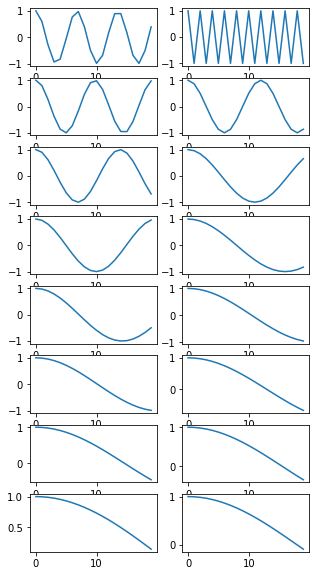

In [14]:
def get_pos_embeddings(seq_len, dimentions):

    pos_vector = torch.arange(0, seq_len).unsqueeze(1).float()
    i_vector = torch.arange(1, dimentions//2 + 1).unsqueeze(0).float()
    dim_signal_freqs = 1e-4**(2*i_vector/dimentions)
    pos_freq_mul = torch.matmul(pos_vector, dim_signal_freqs)

    res = torch.zeros(seq_len, dimentions)
    res[:, ::2] += pos_freq_mul.sin()
    res[:, 1::2] += pos_freq_mul.cos()
    return res

def get_pos_embeddings_simple(seq_len, dimentions):

    pos_vector =  torch.arange(0, seq_len).unsqueeze(1).float()
    dim_signal_freqs = torch.pi/torch.arange(1, dimentions//2 + 1).unsqueeze(0).float()
    pos_freq_mul = torch.matmul(pos_vector, dim_signal_freqs)
    # pos_freq_mul = pos_vector/dim_signal_freqs)
    

    res = torch.zeros(seq_len, dimentions)
    res[:, 0::2] += torch.sin(pos_freq_mul)# .sin()
    res[:, 1::2] += torch.cos(pos_freq_mul)# .cos()
    return res

pos_embs_simple = get_pos_embeddings_simple(80, 256)
pos_embs = get_pos_embeddings(80, 256)

fg, axs = plt.subplots(8, 2)
for i, ax in enumerate(axs[:, 0]):
    ax.plot(pos_embs[:20, 10*i+1])
    ax.figure.set_size_inches((5, 10))
        
for i, ax in enumerate(axs[:, 1]):
    ax.plot(pos_embs_simple[:20, 10*i+1])
    ax.figure.set_size_inches((5, 10))

Text(0, 0.5, 'position')

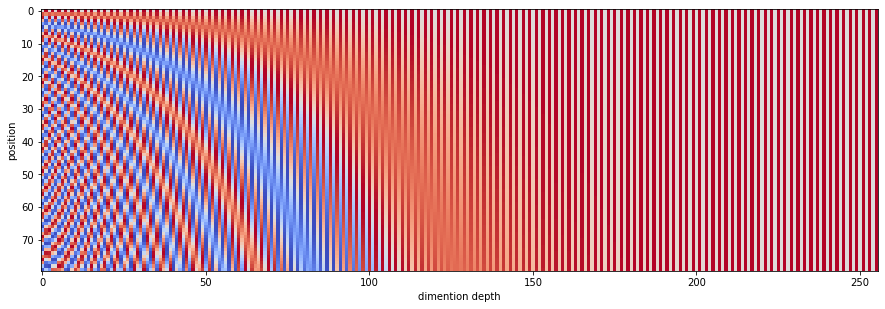

In [15]:
plt.figure(figsize=(15, 5))
plt.imshow(pos_embs, cmap='coolwarm')
plt.xlabel('dimention depth')
plt.ylabel('position')

Text(0, 0.5, 'position')

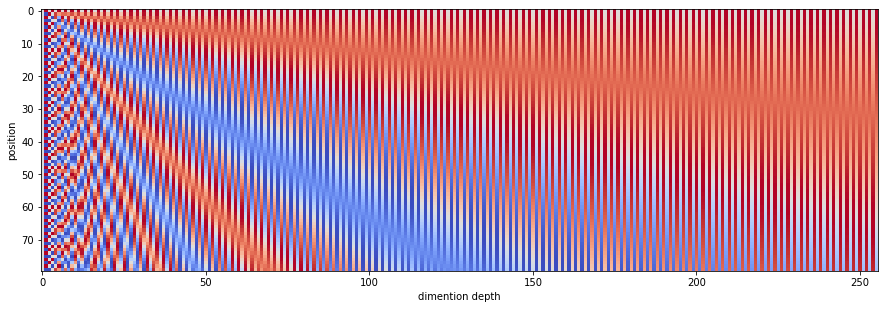

In [16]:
plt.figure(figsize=(15, 5))
plt.imshow(pos_embs_simple, cmap='coolwarm')
plt.xlabel('dimention depth')
plt.ylabel('position')

In [17]:
def get_dependency_mask(size):
    index_expanded = torch.arange(size).unsqueeze(1).expand(-1, size)
    res = torch.where(index_expanded - index_expanded.T < 0, -torch.inf, 0.0)
    return res

In [18]:
class Custom_SelfAttentionMH(torch.nn.Module):
    def __init__(self, d_model, n_heads, droput=0.1):
        super().__init__()
        
        assert d_model % n_heads == 0, 'Model size (d_model) should be divisible by the number of heads (n_heads).'
        self.n_heads = n_heads
        self.query_transform = torch.nn.Linear(d_model, d_model)
        self.key_transform =  torch.nn.Linear(d_model, d_model)
        self.value_transform =  torch.nn.Linear(d_model, d_model)

        self.relevancy_activation = torch.nn.Softmax(dim=-1)
        self.dropout = torch.nn.Dropout(droput)
        self.out_transform = torch.nn.Linear(d_model, d_model)

        self.last_attention_map = None
    
    def forward(self, query_features, key_features, dependency_mask=None, key_padding_mask=None):        

        queries = self.query_transform(query_features)
        keys = self.key_transform(key_features)
        values = self.value_transform(key_features)

        batch_size, keys_max_len, d_model = key_features.shape
        queries_max_len = query_features.shape[1]

        if dependency_mask is None:
            dependency_mask = torch.zeros(queries_max_len, keys_max_len).to(queries.device)

        # Divide queries, keys, and values projections per each head
        # (batch_size, max_seq_len, d_model) -> (batch_size, max_seq_len, n_heads, d_model/n_heads)
        queries_per_head =  queries.view(batch_size, queries_max_len, self.n_heads, -1)
        keys_per_head = keys.view(batch_size, keys_max_len, self.n_heads, -1)
        values_per_head = values.view(batch_size, keys_max_len, self.n_heads, -1)        

        
        qk_relevancy = torch.einsum("bqhe,bkhe->bhqk", (queries_per_head, keys_per_head))
        qk_relevancy = qk_relevancy / math.sqrt(d_model)

        # Expand and apply masks
        key_padding_mask_expanded = key_padding_mask[:, None, None, :].expand_as(qk_relevancy)
        qk_relevancy.masked_fill_(key_padding_mask_expanded, float('-inf'))
        qk_relevancy = qk_relevancy + dependency_mask

        # Activate relevancy logits for an attention scores 
        relevancy_scores = self.relevancy_activation(qk_relevancy)
        relevancy_scores = self.dropout(relevancy_scores)
        self.last_attention_map = relevancy_scores.detach()
        
        # Apply attention scores for tunable values
        aggregated_query = torch.einsum("bhqk,bkhe->bqhe", (relevancy_scores, values_per_head))
        aggregated_query = aggregated_query.reshape(batch_size, queries_max_len, -1)
        res = self.out_transform(aggregated_query)
          
        return res

class CustomEncoder(torch.nn.Module):
    def __init__(self, embedding_size, n_heads, dropout):
        super().__init__()
        self.attention_module = Custom_SelfAttentionMH(embedding_size, n_heads, droput=dropout)
        self.first_dropout = torch.nn.Dropout(dropout)
        self.first_normalization = torch.nn.LayerNorm(embedding_size)
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, embedding_size*2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(embedding_size*2, embedding_size)
        )
        self.second_dropout = torch.nn.Dropout(dropout)
        self.second_normalization = torch.nn.LayerNorm(embedding_size)
    
    def forward(self, encoder_input, dependency_mask, padding_mask):
        attention_output = self.attention_module(encoder_input, encoder_input, dependency_mask, padding_mask)
        attention_output = self.first_dropout(attention_output)
        output = self.first_normalization(attention_output + encoder_input)
        
        ffn_output = self.ffn(output)
        ffn_output = self.second_dropout(ffn_output)
        output = self.second_normalization(ffn_output + output)
        
        return output

class CustomDecoder(torch.nn.Module):
    def __init__(self, embedding_size, n_heads, dropout):
        super().__init__()
        self.attention_module = Custom_SelfAttentionMH(embedding_size, n_heads, droput=dropout)
        self.first_dropout = torch.nn.Dropout(dropout)
        self.first_normalization = torch.nn.LayerNorm(embedding_size)

        self.cross_attention_module = Custom_SelfAttentionMH(embedding_size, n_heads, droput=dropout)
        self.second_dropout = torch.nn.Dropout(dropout)
        self.second_normalization = torch.nn.LayerNorm(embedding_size)

        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, embedding_size*2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(embedding_size*2, embedding_size),
        )
        self.third_dropout = torch.nn.Dropout(dropout)
        self.third_normalization = torch.nn.LayerNorm(embedding_size)
    
    def forward(self, decoder_input, encoder_output, dependency_mask, src_padding_mask, tgt_padding_mask):
        self_attention_output = self.attention_module(decoder_input, decoder_input, dependency_mask, tgt_padding_mask)
        self_attention_output = self.first_dropout(self_attention_output)
        self_attention_output = self.first_normalization(self_attention_output + decoder_input)

        cross_attention_output = self.cross_attention_module(self_attention_output, encoder_output, key_padding_mask=src_padding_mask)
        cross_attention_output = self.second_dropout(cross_attention_output)
        cross_attention_output = self.second_normalization(cross_attention_output + self_attention_output)

        ffn_output = self.ffn(cross_attention_output)
        ffn_output = self.third_dropout(ffn_output)
        output = self.third_normalization(ffn_output + cross_attention_output)
        
        return output

class CustomEncoderStack(torch.nn.Module):
    def __init__(self, encoder, n_layers) -> None:
        super().__init__()
        self.module_layers = torch.nn.ModuleList([copy.deepcopy(encoder) for layer in range(n_layers)])
        self.n_layers = n_layers
        self.init_weights()
    
    def forward(self, encoder_input, dependency_mask, src_padding_mask):
        for layer in self.module_layers:
            encoder_input = layer(encoder_input, dependency_mask, src_padding_mask)
        return encoder_input
    
    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

class CustomDecoderStack(torch.nn.Module):
    def __init__(self, decoder, n_layers) -> None:
        super().__init__()
        self.module_layers = torch.nn.ModuleList([copy.deepcopy(decoder) for layer in range(n_layers)])
        self.n_layers = n_layers
        self.init_weights()
    
    def forward(self, tgt_input, encoder_output, dependency_mask, src_padding_mask, tgt_padding_mask):
        for layer in self.module_layers:
            decoder_input = layer(tgt_input, encoder_output, dependency_mask, src_padding_mask, tgt_padding_mask)
        return decoder_input
    
    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

class CustomTransformer(torch.nn.Module):
    def __init__(self, d_model=512, n_encoder_layers=6, n_decoder_layers=6, n_heads=8, dropout=0.1) -> None:
        super().__init__()
        encoder = CustomEncoder(d_model, n_heads, dropout=dropout)
        decoder = CustomDecoder(d_model, n_heads, dropout=dropout)
        self.encoder = CustomEncoderStack(encoder, n_layers=n_encoder_layers)
        self.decoder = CustomDecoderStack(decoder, n_layers=n_decoder_layers)
    
    def forward(self, src_embs, tgt_embs, src_mask, tgt_mask, memory_mask, src_padding_mask, tgt_key_padding_mask, memory_key_padding_mask):
        encoder_output = self.encoder(src_embs, src_mask, src_padding_mask)
        decoder_output = self.decoder(tgt_embs, encoder_output, tgt_mask, memory_key_padding_mask, tgt_key_padding_mask)
        return decoder_output

In [19]:
class Seq2SeqTransformer(torch.nn.Module):
    def __init__(self, backbone, src_vocabulary_size, tgt_vocabulary_size, d_model, pos_emb_function=get_pos_embeddings, dropout=0.1, pad_token_id=0, device='cpu') -> None:
        super().__init__()
        self.src_embeddings = torch.nn.Embedding(src_vocabulary_size, d_model)
        self.tgt_embeddings = torch.nn.Embedding(tgt_vocabulary_size, d_model)
        self.emb_dropout = torch.nn.Dropout(dropout)        
        
        self.pos_emb_function = pos_emb_function
        self.backbone = backbone
        self.out_transorm = torch.nn.Linear(d_model, tgt_vocabulary_size)

        self.device = device
        self.pad_token_id = pad_token_id
    
    def forward(self, src_ids, tgt_ids):
        src_embs = self.src_embeddings(src_ids)        
        tgt_embs = self.tgt_embeddings(tgt_ids)
        
        src_embs = src_embs + get_pos_embeddings(src_embs.shape[-2], src_embs.shape[-1]).to(src_embs.device)
        tgt_embs = tgt_embs + get_pos_embeddings(tgt_embs.shape[-2], tgt_embs.shape[-1]).to(tgt_embs.device)        

        src_embs = self.emb_dropout(src_embs)
        tgt_embs = self.emb_dropout(tgt_embs)

        batch_size, src_seq_len, d_model = src_embs.shape
        tgt_seq_len = tgt_ids.shape[-1]

        src_pad_mask = src_ids == self.pad_token_id
        tgt_pad_mask = tgt_ids == self.pad_token_id
        src_dependency_mask = torch.zeros(src_ids.shape[-1], src_ids.shape[-1]).to(self.device)
        tgt_dependency_mask = get_dependency_mask(tgt_seq_len).to(self.device)

        prediction = self.backbone(src_embs, tgt_embs, src_dependency_mask, tgt_dependency_mask, None, src_pad_mask, tgt_pad_mask, src_pad_mask)

        out_logits = self.out_transorm(prediction)
        return out_logits

### Model init

In [20]:
INP_VOC_SIZE = len(vocabulary[SRC_LANGUAGE])
OUT_VOC_SIZE = len(vocabulary[TGT_LANGUAGE])
N_ENCODERS  = 3
N_DECODERS = 3
EMB_SIZE = 256
DROPOUT = 0.1

In [38]:
torch_transformer = torch.nn.Transformer(
    d_model=EMB_SIZE, 
    num_encoder_layers=N_ENCODERS, 
    num_decoder_layers=N_DECODERS, 
    nhead=8, 
    batch_first=True, 
    dim_feedforward=EMB_SIZE*2
)

In [21]:
custom_transformer = CustomTransformer(
    d_model=EMB_SIZE, 
    n_encoder_layers=N_ENCODERS, 
    n_decoder_layers=N_DECODERS, 
    n_heads=8,
    dropout=0.1
)

In [39]:
torch_model = Seq2SeqTransformer(torch_transformer, INP_VOC_SIZE, OUT_VOC_SIZE, EMB_SIZE, device='cuda').to('cuda')

In [22]:
custom_model = Seq2SeqTransformer(custom_transformer, INP_VOC_SIZE, OUT_VOC_SIZE, EMB_SIZE, device='cuda').to('cuda')

In [41]:
from functools import reduce
sum(reduce(lambda x, y: x*y, p.shape) for p in torch_model.parameters())

46426257

In [23]:
from functools import reduce
sum(reduce(lambda x, y: x*y, p.shape) for p in custom_model.parameters())

46425233

In [24]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        torch.nn.init.xavier_uniform_(m.weight.data)

In [57]:
init_random_seed()
torch_model.apply(initialize_weights)

Seq2SeqTransformer(
  (src_embeddings): Embedding(90716, 256)
  (tgt_embeddings): Embedding(37521, 256)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (backbone): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): 

In [25]:
init_random_seed()
custom_model.apply(initialize_weights)

Seq2SeqTransformer(
  (src_embeddings): Embedding(90716, 256)
  (tgt_embeddings): Embedding(37521, 256)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (backbone): CustomTransformer(
    (encoder): CustomEncoderStack(
      (module_layers): ModuleList(
        (0): CustomEncoder(
          (attention_module): Custom_SelfAttentionMH(
            (query_transform): Linear(in_features=256, out_features=256, bias=True)
            (key_transform): Linear(in_features=256, out_features=256, bias=True)
            (value_transform): Linear(in_features=256, out_features=256, bias=True)
            (relevancy_activation): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (out_transform): Linear(in_features=256, out_features=256, bias=True)
          )
          (first_dropout): Dropout(p=0.1, inplace=False)
          (first_normalization): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=256, o

### Train/Eval utils

In [27]:
def produce_epoch_train(model, optimizer, loss_foo, train_dataloader):
    train_start_time = time.time()
    model.train()
    batch_loss = 0
    for batch_idx, (src_ids, tgt_ids) in enumerate(train_dataloader):
        optimizer.zero_grad()
        src_ids = src_ids.to(model.device)
        tgt_ids = tgt_ids.to(model.device)
        tgt_ids_input = tgt_ids[:, :-1]
        tgt_ids_output = tgt_ids[:, 1:].flatten()
        predictions = model(src_ids, tgt_ids_input)
        predictions = predictions.view(-1, OUT_VOC_SIZE)
        loss = loss_foo(predictions, tgt_ids_output)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
    epoch_mean_loss = batch_loss/(batch_idx + 1)
    training_time = time.time() - train_start_time
    return epoch_mean_loss, training_time

In [28]:
def produce_epoch_eval(model, loss_foo, eval_dataloader):
    eval_start_time = time.time()
    model.eval()
    batch_loss = 0
    with torch.no_grad():
        for batch_idx, (src_ids, tgt_ids) in enumerate(eval_dataloader):
            src_ids = src_ids.to(model.device)
            tgt_ids = tgt_ids.to(model.device)
            tgt_ids_input = tgt_ids[:, :-1]
            tgt_ids_output = tgt_ids[:, 1:].flatten()
            predictions = model(src_ids, tgt_ids_input)
            predictions = predictions.view(-1, OUT_VOC_SIZE)
            loss = loss_foo(predictions, tgt_ids_output)
            batch_loss += loss.item()
    epoch_mean_loss = batch_loss/(batch_idx + 1)
    eval_time = time.time() - eval_start_time
    return epoch_mean_loss, eval_time

### Torch Transformer Train/Eval process

In [230]:
loss_foo = torch.nn.CrossEntropyLoss(ignore_index=spec_tokens_mapping[PAD_TOKEN])

LEARNING_RATE = 5e-4

optimizer = torch.optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)

In [59]:
MAX_EPOCH = 10

In [60]:
def produce_epoch_train(model, optimizer, loss_foo, train_dataloader):
    train_start_time = time.time()
    model.train()
    batch_loss = 0
    for batch_idx, (src_ids, tgt_ids) in enumerate(train_dataloader):
        optimizer.zero_grad()
        src_ids = src_ids.to(model.device)
        tgt_ids = tgt_ids.to(model.device)
        tgt_ids_input = tgt_ids[:, :-1]
        tgt_ids_output = tgt_ids[:, 1:].flatten()
        predictions = model(src_ids, tgt_ids_input)
        predictions = predictions.view(-1, OUT_VOC_SIZE)
        loss = loss_foo(predictions, tgt_ids_output)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
    epoch_mean_loss = batch_loss/(batch_idx + 1)
    training_time = time.time() - train_start_time
    return epoch_mean_loss, training_time

In [228]:
def produce_epoch_eval(model, loss_foo, eval_dataloader):
    eval_start_time = time.time()
    model.eval()
    batch_loss = 0
    with torch.no_grad():
        for batch_idx, (src_ids, tgt_ids) in enumerate(eval_dataloader):
            src_ids = src_ids.to(model.device)
            tgt_ids = tgt_ids.to(model.device)
            tgt_ids_input = tgt_ids[:, :-1]
            tgt_ids_output = tgt_ids[:, 1:].flatten()
            predictions = model(src_ids, tgt_ids_input)
            predictions = predictions.view(-1, OUT_VOC_SIZE)
            loss = loss_foo(predictions, tgt_ids_output)
            batch_loss += loss.item()
    epoch_mean_loss = batch_loss/(batch_idx + 1)
    eval_time = time.time() - eval_start_time
    return epoch_mean_loss, eval_time

In [62]:

train_loss = []
eval_loss = []
for epoch_idx in range(MAX_EPOCH):
    epoch_train_loss, epoch_train_time = produce_epoch_train(torch_model, optimizer, loss_foo, train_dataloader)
    train_loss.append(epoch_train_loss)
    
    epoch_eval_loss, epoch_eval_time = produce_epoch_eval(torch_model, loss_foo, eval_dataloader)
    eval_loss.append(epoch_eval_loss)
    print(
        'Epoch Number:', epoch_idx + 1, 
        '\t| Training time:', f'{int(epoch_train_time// 60)}:{int(epoch_train_time % 60)}', 
        '\t| Evaluation time:', f'{int(epoch_eval_time // 60)}:{int(epoch_eval_time % 60)}', 
        '\t| epoch train loss:', train_loss[-1], 
        '\t| epoch eval loss:', eval_loss[-1]
    )
    print()

Epoch Number: 1 	| Training time: 5:52 	| Evaluation time: 0:41 	| epoch train loss: 4.525257097374874 	| epoch eval loss: 3.7191786284248036

Epoch Number: 2 	| Training time: 5:52 	| Evaluation time: 0:41 	| epoch train loss: 3.5619012960768295 	| epoch eval loss: 3.1939147032797335

Epoch Number: 3 	| Training time: 5:52 	| Evaluation time: 0:41 	| epoch train loss: 3.1279337950075785 	| epoch eval loss: 2.943246086438497

Epoch Number: 4 	| Training time: 5:52 	| Evaluation time: 0:41 	| epoch train loss: 2.8649323368143493 	| epoch eval loss: 2.7965494049092134

Epoch Number: 5 	| Training time: 5:52 	| Evaluation time: 0:41 	| epoch train loss: 2.6836485718101386 	| epoch eval loss: 2.706109568228324

Epoch Number: 6 	| Training time: 5:51 	| Evaluation time: 0:41 	| epoch train loss: 2.5480497079486515 	| epoch eval loss: 2.645817988117536

Epoch Number: 7 	| Training time: 5:50 	| Evaluation time: 0:41 	| epoch train loss: 2.442246436895293 	| epoch eval loss: 2.612685878574848

In [233]:
print('Test loss:', produce_epoch_eval(torch_model, loss_foo, test_dataloader)[0])

Test loss: 2.521548043018525


### Torch Transformer Inference

In [38]:
def translate(seed_text, model, max_gen_len=50):
    model.eval()
    tokenized_src = [BOS_TOKEN] + doc_tokenizer(seed_text, SRC_LANGUAGE) + [EOS_TOKEN]
    encoded_src = torch.LongTensor([vocabulary[SRC_LANGUAGE].token2id.get(token, 3) for token in tokenized_src]).unsqueeze(0).to(model.device)
    src_embs = model.src_embeddings(encoded_src)
    src_embs = src_embs + get_pos_embeddings(src_embs.shape[-2], src_embs.shape[-1]).to(model.device)
    src_padding_mask = (encoded_src == 0)
    src_dependency_mask = torch.zeros(encoded_src.shape[-1], encoded_src.shape[-1]).to(model.device)
    with torch.no_grad():
        encoder_out = model.backbone.encoder(src_embs, src_dependency_mask, src_padding_mask)

    encoded_tgt = torch.LongTensor([spec_tokens_mapping[BOS_TOKEN]]).unsqueeze(0).to(model.device)

    while encoded_tgt.shape[-1] < max_gen_len and encoded_tgt[0][-1] != spec_tokens_mapping[EOS_TOKEN]:
        tgt_embs = model.tgt_embeddings(encoded_tgt)
        tgt_embs = tgt_embs + get_pos_embeddings(tgt_embs.shape[-2], tgt_embs.shape[-1]).to(model.device)
        tgt_padding_mask = (encoded_tgt == 0)
        tgt_dependency_mask = get_dependency_mask(encoded_tgt.shape[-1]).to(model.device)
        with torch.no_grad():
            decoder_out = model.backbone.decoder(tgt_embs, encoder_out, tgt_dependency_mask, tgt_padding_mask=tgt_padding_mask, src_padding_mask=src_padding_mask)
            out_logits = model.out_transorm(decoder_out)
        encoded_tgt = torch.cat((encoded_tgt, out_logits[0][-1].argmax().unsqueeze(0).unsqueeze(0)), -1)
    res = ' '.join([vocabulary[TGT_LANGUAGE][token_id] for token_id in encoded_tgt[0].tolist() if token_id not in [1, 2, 3]])
    return res

In [247]:
random_idxes = np.random.randint(0, len(eval_src_tokenized),  5)
for idx in random_idxes:
    sample_text = ' '.join(eval_src_tokenized[idx])
    tgt_text = ' '.join(eval_tgt_tokenized[idx])
    print('SRC text:\t', sample_text)
    print('TGT text:\t', tgt_text)
    print('PREDICTED:\t', translate(sample_text, torch_model))
    print()

SRC text:	 так она установила маленькое существо вниз , и чувствовал себя с облегчением увидеть его рысью прочь спокойно в лес .
TGT text:	 so she set the little creature down , and felt quite relieved to see it trot away quietly into the wood .
PREDICTED:	 so she set up a little creature down , and felt compelled to see him , go to the forest

SRC text:	 их связывает и очевидное , и то , чего мы не видим .
TGT text:	 what they have in common is what we see unlocks what we can not see .
PREDICTED:	 they connect and obvious and what we do n't see

SRC text:	 ну и выпендрёжный подзаголовок . " дарвин в стране выделений "
TGT text:	 and i also have a little bit of a sort of smartass subtitle to this .
PREDICTED:	 well , the of the , darwin in the country "

SRC text:	 ильза , присмотри за ней .
TGT text:	 ilse , take care of her , wo n't you ?
PREDICTED:	 ilse , take care of her

SRC text:	 существует не так .
TGT text:	 there is not .
PREDICTED:	 there is no way



### Custom Transformer Train/Eval process

In [26]:
loss_foo = torch.nn.CrossEntropyLoss(ignore_index=spec_tokens_mapping[PAD_TOKEN])

LEARNING_RATE = 5e-4

optimizer = torch.optim.Adam(custom_model.parameters(), lr=LEARNING_RATE)

In [30]:
MAX_EPOCH = 10

In [31]:
train_loss = []
eval_loss = []
for epoch_idx in range(MAX_EPOCH):
    epoch_train_loss, epoch_train_time = produce_epoch_train(custom_model, optimizer, loss_foo, train_dataloader)
    train_loss.append(epoch_train_loss)
    
    epoch_eval_loss, epoch_eval_time = produce_epoch_eval(custom_model, loss_foo, eval_dataloader)
    eval_loss.append(epoch_eval_loss)
    print(
        'Epoch Number:', epoch_idx + 1, 
        '\t| Training time:', f'{int(epoch_train_time// 60)}:{int(epoch_train_time % 60)}', 
        '\t| Evaluation time:', f'{int(epoch_eval_time // 60)}:{int(epoch_eval_time % 60)}', 
        '\t| epoch train loss:', train_loss[-1], 
        '\t| epoch eval loss:', eval_loss[-1]
    )
    print()

Epoch Number: 1 	| Training time: 5:13 	| Evaluation time: 0:41 	| epoch train loss: 5.005260813755309 	| epoch eval loss: 4.488527601460616

Epoch Number: 2 	| Training time: 5:12 	| Evaluation time: 0:41 	| epoch train loss: 4.353161863824626 	| epoch eval loss: 4.059948286165794

Epoch Number: 3 	| Training time: 5:13 	| Evaluation time: 0:41 	| epoch train loss: 3.9099624979482694 	| epoch eval loss: 3.6545518770813943

Epoch Number: 4 	| Training time: 5:12 	| Evaluation time: 0:41 	| epoch train loss: 3.5220086487598654 	| epoch eval loss: 3.3041818492114543

Epoch Number: 5 	| Training time: 5:12 	| Evaluation time: 0:41 	| epoch train loss: 3.2043321173475894 	| epoch eval loss: 3.0970352202653886

Epoch Number: 6 	| Training time: 5:12 	| Evaluation time: 0:41 	| epoch train loss: 2.9823273536127033 	| epoch eval loss: 2.976827843487263

Epoch Number: 7 	| Training time: 5:13 	| Evaluation time: 0:41 	| epoch train loss: 2.8227254431355076 	| epoch eval loss: 2.898564374695221

In [32]:
print('Test loss:', produce_epoch_eval(custom_model, loss_foo, test_dataloader)[0])

Test loss: 2.775691553386902


### Custom Transformer Inference

In [39]:
random_idxes = np.random.randint(0, len(eval_src_tokenized),  5)
for idx in random_idxes:
    sample_text = ' '.join(eval_src_tokenized[idx])
    tgt_text = ' '.join(eval_tgt_tokenized[idx])
    print('SRC text:\t', sample_text)
    print('TGT text:\t', tgt_text)
    print('PREDICTED:\t', translate(sample_text, custom_model))
    print()

SRC text:	 итак , какие отношения она ? так контракт , это замечательно , десять заповедей удивительные а , что письма , плавающих в воздухе дочери , последнее , что я хочу поговорить о матери
TGT text:	 so what kind of relationship it ? contract is wonderful , the ten commandments are amazing but that letters floating in the air daughters , the last thing i want to talk it about mother
PREDICTED:	 so what relationship she 's doing ? so it 's a great ten commandments and the letters of amazing , ten commandments and what letters in the air daughters , the last thing i want to talk about mom

SRC text:	 у меня есть сорок девять карт , ожидающих того , чтобы в них поиграли и джокер из другой колоды !
TGT text:	 i got forty nine cards ready to be played with and a joker from another deck !
PREDICTED:	 i have forty nine cards , waiting for them to get to their work and the minotaur

SRC text:	 автомобиль тоже входит в круг таких интересов , и ребенок может сесть за руль и поехать .
TGT tex

In [42]:
translate("Доброй ночи и сладких снов!", custom_model)

'good night and pleasant sleep !'

In [43]:
translate("Наконец модель работает!", custom_model)

'finally , the model works !'

### Calculate Torch Transformer BLEU metric

In [42]:
def unsupervised_layerwise_prediction(model, test_dataloader, max_gen_len=50):
    model.eval()
    tgt_ids_list = []
    for batch_idx, (src_ids, tgt_gt_ids) in enumerate(test_dataloader):
        ended_seq_set = set()
        torch.cuda.empty_cache()
        batch_ids = torch.empty(test_dataloader.batch_size, 1).fill_(spec_tokens_mapping[BOS_TOKEN]).type(torch.long).to(model.device)
        generated_len = 1
        src_ids = src_ids.to(model.device)    
        src_embs = model.src_embeddings(src_ids)
        src_embs = src_embs + get_pos_embeddings(src_embs.shape[-2], src_embs.shape[-1]).to(model.device)
        src_padding_mask = (src_ids == 0)
        src_dependency_mask = torch.zeros(src_ids.shape[-1], src_ids.shape[-1]).to(model.device)
        with torch.no_grad():
            encoder_out = model.backbone.encoder(src_embs, src_dependency_mask, src_padding_mask)

        while len(ended_seq_set) < test_dataloader.batch_size and generated_len < max_gen_len:
            generated_len += 1
            tgt_embs = model.tgt_embeddings(batch_ids)
            tgt_embs = tgt_embs + get_pos_embeddings(tgt_embs.shape[-2], tgt_embs.shape[-1]).to(model.device)
            tgt_padding_mask = (batch_ids == 0)
            tgt_dependency_mask = get_dependency_mask(batch_ids.shape[-1]).to(model.device)
            with torch.no_grad():
                model_out = model.backbone.decoder(tgt_embs, 
                                                     encoder_out, 
                                                     tgt_dependency_mask, 
                                                     memory_key_padding_mask=src_padding_mask, 
                                                     tgt_key_padding_mask=tgt_padding_mask)
                model_out = model.out_transorm(model_out)
            model_out = model_out[:, -1].argmax(1)
            ended_seqs_idxes = ((model_out == spec_tokens_mapping[EOS_TOKEN]).float()).nonzero().flatten().tolist()
            for el in ended_seqs_idxes:
                ended_seq_set.add(el)
            batch_ids = torch.cat((batch_ids, model_out.unsqueeze(1)), -1)      
        tgt_ids_list.append(batch_ids.tolist())
        if (batch_idx + 1)/len(test_dataloader) % .25 == .0:
            print(batch_idx, 'batch done')
            print('overall progress', (batch_idx + 1)/len(test_dataloader))
    return tgt_ids_list

In [43]:
tgt_ids = unsupervised_layerwise_prediction(torch_model, test_dataloader)

766 batch done
overall progress 1.0


In [45]:
predicted_tokenized_test_corpus = []
for batch in tgt_ids:
    for doc in batch:
        tokenized_doc = []
        for token_id in doc:
            if token_id not in (0, 1, 2, 3):
                tokenized_doc.append(vocabulary[TGT_LANGUAGE][token_id])
            elif token_id == spec_tokens_mapping[EOS_TOKEN]:
                break
        predicted_tokenized_test_corpus.append(tokenized_doc)

In [130]:
ref_tokenized_test_corpus = []
for doc in test_tgt_encoded:
    tokenized_doc = []
    for token_id in doc:
        if token_id not in (0, 1, 2, 3):
            tokenized_doc.append(vocabulary[TGT_LANGUAGE][token_id])
        elif token_id == spec_tokens_mapping[EOS_TOKEN]:
            break
    ref_tokenized_test_corpus.append(tokenized_doc)

In [225]:
bleu_score(predicted_tokenized_test_corpus, ref_tokenized_test_corpus[:-22], max_n=2, weights=[0.5, 0.5])

0.0012915174011141062

In [226]:
bleu_score(predicted_tokenized_test_corpus, ref_tokenized_test_corpus[:-22], max_n=1, weights=[1])

0.0782439261674881